In [56]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.model_selection import KFold
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights
import os
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.transforms import v2

In [2]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # store tumor type in self.labels (0 = non-recurrent, 1 = recurrent)
        for img in self.image_files:
            if "positive" in img:
                self.labels.append(1)
            else:
                self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        channel = "_".join(self.image_files[idx].split('/')[-1].split('_')[:2]) # get the channel of the image
        label = self.labels[idx]  # Get the corresponding label
        
        if self.transform:
            image = self.transform(image)
            
        return image, channel, label  # Return both image and label


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to 224x224 (if not already)
    transforms.ToTensor(), # convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/einstein_patches/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

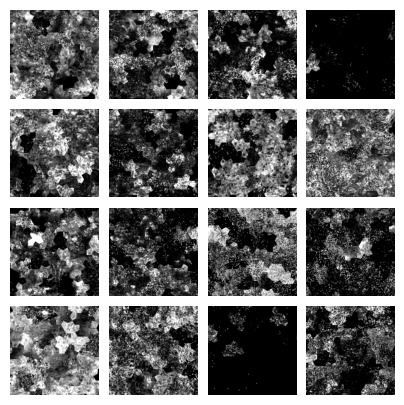

In [4]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, channels, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [5]:
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.patch_dict = defaultdict(list)
        self.labels = []
        self.samples = []
        self.channels = []
        
        # populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            if not os.path.isdir(full_path):
                continue
                
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
           
            for img_path in full_image_path:
                img_array = self._load_image_as_tensor(img_path)
                # use the index of the patch along with its category (positive/negative) as key for the dictionary
                sample_key = os.path.basename(img_path)[-5]
                if "positive" in img_path:
                    sample_key = "positive" + "_" + sample_key
                else:
                    sample_key = "negative" + "_" + sample_key
                self.patch_dict[sample_key].append(img_array)
                
        # convert the dictionary into list so we can get the samples by indexing
        for patch in self.patch_dict:
            self.samples.append([]) # create a new list for each "sample"
            self.samples[-1].extend(self.patch_dict[patch]) # add the patch to the list
            if "positive" in patch:
                self.labels.append(1)
            elif "negative" in patch:
                self.labels.append(0)
            self.channels.append("None")
       
    def _load_image_as_tensor(self, path):
        """
        Load an image as a tensor.
       
        Args:
            path (str): Path to image file
           
        Returns:
            torch.Tensor: Image as tensor with shape [1, H, W]
        """
        # open image using PIL
        with Image.open(path) as img:
            # convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # convert to NumPy array
            img_np = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            # transform the tensor if needed
            if self.transform:
                img_tensor = self.transform(img_tensor)
        return img_tensor
    
    def __len__(self):
        return len(self.samples)
       
    def __getitem__(self, idx):
        patch = self.samples[idx]
        channel = self.channels[idx] # for multi-channel dataset, there is no individual channel information (subject to change)
        label = self.labels[idx]
       
        # stack list of images for each tissue to form a multi-channel tensor
        sample_tensor = torch.stack(patch, dim=0)  # Shape: [num_channels, 1, H, W]
        sample_tensor = sample_tensor.squeeze(1)  # Remove the color channel, shape: [num_channels, H, W]
        
        # convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
           
        return sample_tensor, channel, label

In [6]:
import torch
import torch.nn as nn
from torchvision.models import convnext_tiny, convnext_small, convnext_base, ConvNeXt_Tiny_Weights, ConvNeXt_Small_Weights, ConvNeXt_Base_Weights

# Create LayerNorm2d for older PyTorch versions
class LayerNorm2d(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.normalized_shape = (normalized_shape,)
    
    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


# simplified version that's more compatible
class MultiChannelConvNeXtSimple(nn.Module):
    """Simplified version that modifies ConvNeXt for multi-channel input"""
    
    def __init__(self, num_channels=50, num_classes=2, dropout_p=0.5, model_size='tiny'):
        super(MultiChannelConvNeXtSimple, self).__init__()
        
        if model_size == 'tiny':
            self.model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
        elif model_size == 'small':
            self.model = convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)
        elif model_size == 'base':
            self.model = convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)
        else:
            raise ValueError(f"Invalid model_size: {model_size}")
        
        # modify the first conv layer
        original_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            num_channels,
            original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=(original_conv.bias is not None)
        )
        
        # initialize weights
        with torch.no_grad():
            scale = 3.0 / num_channels
            if num_channels >= 3:
                new_conv.weight[:, :3] = original_conv.weight * scale
                if num_channels > 3:
                    nn.init.kaiming_normal_(new_conv.weight[:, 3:], mode='fan_out')
                    new_conv.weight[:, 3:] *= scale
            else:
                new_conv.weight = nn.Parameter(original_conv.weight[:, :num_channels] * scale)
            
            if original_conv.bias is not None:
                new_conv.bias = nn.Parameter(original_conv.bias.clone())
        
        # replace the first conv to allow for multi-channel input
        self.model.features[0][0] = new_conv
        
        # get the final feature size
        dummy_input = torch.zeros(1, num_channels, 224, 224)
        with torch.no_grad():
            features = self.model.features(dummy_input)
            feature_size = features.shape[1]
        
        # replace classifier
        self.model.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Dropout(dropout_p),
            nn.Linear(feature_size, num_classes)
        )
    
    def forward(self, x):
        x = self.model.features(x)
        x = self.model.classifier(x)
        return x

In [7]:
from itertools import zip_longest
def train_model_with_visualization(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    test_loader, 
    epochs=20, 
    train_loss_delta_threshold=0.05, 
    test_loss_delta_threshold=0.05, 
    moving_avg_window=3
):
    """
    Train the model and visualize metrics, with optional early stopping based on moving average loss change thresholds.

    args:
        model: the neural network model.
        criterion: loss function.
        optimizer: optimizer.
        train_loader: dataloader for training data.
        test_loader: dataloader for test/validation data.
        epochs: maximum number of epochs to train.
        train_loss_delta_threshold: if set, stop training early if the moving average change in training loss is below this value.
        test_loss_delta_threshold: if set, stop training early if the moving average change in test/validation loss is below this value.
        moving_avg_window: number of epochs to use for moving average delta calculation.

    returns:
        train_losses, val_losses, train_accs, test_accs
    """
    # lists to store metrics for visualization
    train_losses = []
    val_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, channels, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        # store training metrics
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        # testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, channels, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        
        val_losses.append(test_loss)
        test_accs.append(test_accuracy)
        
        print(f'epoch {epoch+1}/{epochs}, '
              f'Train loss: {train_loss:.4f}, Train acc: {train_accuracy:.4f}, '
              f'Val loss: {test_loss:.4f}, Val acc: {test_accuracy:.4f}')
        epoch_trained = epoch+1
        # early stopping based on moving average loss change thresholds
        stop_train = False
        # only check if we have enough epochs for the moving average window
        if epoch >= moving_avg_window:
            # compute moving average deltas for train and test loss
            train_loss_deltas = [
                abs(train_losses[i] - train_losses[i-1]) 
                for i in range(-moving_avg_window+1, 0)
            ]
            test_loss_deltas = [
                abs(val_losses[i] - val_losses[i-1]) 
                for i in range(-moving_avg_window+1, 0)
            ]
            avg_train_loss_delta = sum(train_loss_deltas) / len(train_loss_deltas)
            avg_test_loss_delta = sum(test_loss_deltas) / len(test_loss_deltas)
            if train_loss_delta_threshold is not None and avg_train_loss_delta < train_loss_delta_threshold and test_accuracy > 0.8:
                print(f"Early stopping: moving average change in training loss {avg_train_loss_delta:.6f} < threshold {train_loss_delta_threshold}")
                stop_train = True
            if test_loss_delta_threshold is not None and avg_test_loss_delta < test_loss_delta_threshold and test_accuracy > 0.8:
                print(f"Early stopping: moving average change in validation loss {avg_test_loss_delta:.6f} < threshold {test_loss_delta_threshold}")
                stop_train = True
        if stop_train:
            break
    
    return train_losses, val_losses, train_accs, test_accs, epoch_trained

def plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs, title, file_location = "../data/output/", filename = "training_metrics.png"):
    """
    Plot training and validation metrics.
    
    args:
        train_losses: list of training losses per epoch
        val_losses: list of validation losses per epoch
        train_accs: list of training accuracies per epoch
        test_accs: list of validation accuracies per epoch
        epochs: number of training epochs
    """
    epochs_range = range(1, len(train_losses) + 1)
    # make sure the output directory exists
    os.makedirs(file_location, exist_ok=True)
    plt.figure(figsize=(12, 5))
    
    # plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title(f'Training and Validation Loss  for {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{file_location}/{filename}", dpi=300, bbox_inches='tight')
    plt.show()



--- Fold 1 ---
epoch 1/20, Train loss: 2.1072, Train acc: 0.4167, Val loss: 1.4613, Val acc: 0.1667
epoch 2/20, Train loss: 1.9028, Train acc: 0.6667, Val loss: 1.6704, Val acc: 0.1667
epoch 3/20, Train loss: 1.9619, Train acc: 0.6667, Val loss: 1.8016, Val acc: 0.1667
epoch 4/20, Train loss: 1.8829, Train acc: 0.6667, Val loss: 1.7259, Val acc: 0.1667
epoch 5/20, Train loss: 1.8916, Train acc: 0.6667, Val loss: 1.7457, Val acc: 0.1667
epoch 6/20, Train loss: 1.8456, Train acc: 0.6667, Val loss: 1.6830, Val acc: 0.1667
epoch 7/20, Train loss: 1.7632, Train acc: 0.6667, Val loss: 1.6367, Val acc: 0.1667
epoch 8/20, Train loss: 1.5727, Train acc: 0.6667, Val loss: 1.6200, Val acc: 0.1667
epoch 9/20, Train loss: 1.2750, Train acc: 0.7500, Val loss: 1.3700, Val acc: 0.1667
epoch 10/20, Train loss: 1.1200, Train acc: 0.8333, Val loss: 1.1100, Val acc: 0.6667
epoch 11/20, Train loss: 0.7767, Train acc: 1.0000, Val loss: 0.8145, Val acc: 0.8333
epoch 12/20, Train loss: 0.6412, Train acc: 1.0

Exception ignored in: <function _ConnectionBase.__del__ at 0x774bccdebd30>
Traceback (most recent call last):
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/multiprocessing/connection.py", line 137, in __del__
    self._close()
  File "/root/anaconda3/envs/mass_spec_img/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


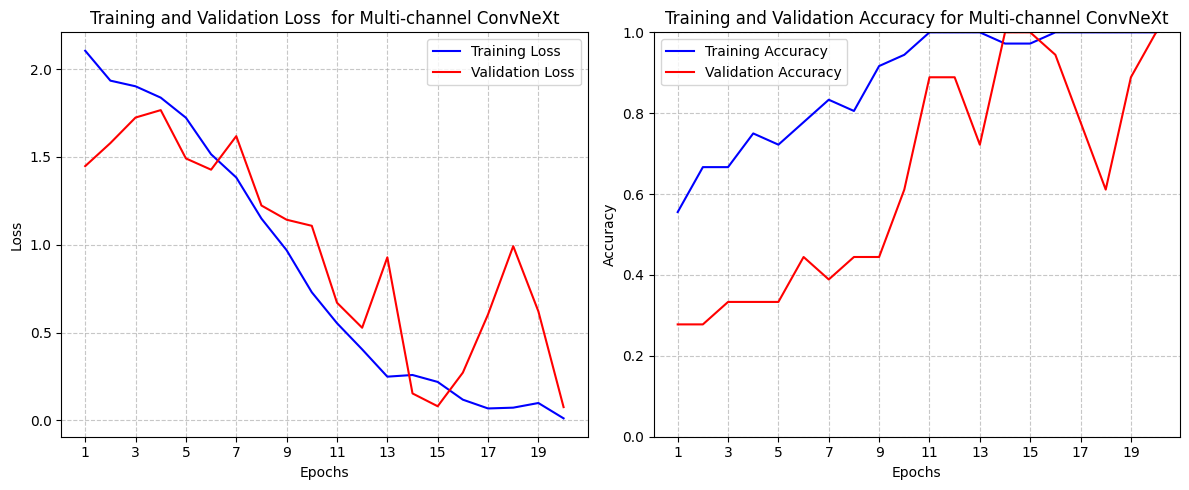

In [11]:
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# use 3-fold cross-validation because there are 18 samples in the dataset
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(multi_channel_dataset))))

# rerun training with the best hyperparameters
fold_results = []
train_losses_per_fold, val_losses_per_fold, train_accs_per_fold, val_accs_per_fold, epochs_per_fold = [], [], [], [], []
for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    mc_train_dataset = Subset(multi_channel_dataset, train_idx)
    mc_test_dataset = Subset(multi_channel_dataset, test_idx)

    mc_train_loader = DataLoader(
        mc_train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=4
    )

    mc_test_loader = DataLoader(
        mc_test_dataset, 
        batch_size=4, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    multi_channel_model = MultiChannelConvNeXtSimple(num_channels=84, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
    multi_channel_model.parameters(), 
    lr=5e-5,
    weight_decay=0.05,
    betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=20, 
    eta_min=1e-6
    )

    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs, epoch_trained = train_model_with_visualization(
        multi_channel_model, criterion, optimizer, mc_train_loader, mc_test_loader, 
        train_loss_delta_threshold=0.02, test_loss_delta_threshold=0.02, moving_avg_window=3
    )
    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)
    train_accs_per_fold.append(train_accs)
    val_accs_per_fold.append(val_accs)
    epochs_per_fold.append(epoch_trained)

# average results across folds
zipped_val_losses = zip_longest(*val_losses_per_fold, fillvalue=None)
zipped_train_losses = zip_longest(*train_losses_per_fold, fillvalue=None)
zipped_train_accs = zip_longest(*train_accs_per_fold, fillvalue=None)
zipped_val_accs = zip_longest(*val_accs_per_fold, fillvalue=None)
avg_val_losses, avg_train_losses, avg_train_accs, avg_val_accs = [], [], [], []

for avg_list in [zipped_val_losses, zipped_train_losses, zipped_train_accs, zipped_val_accs]:
    average_values = []
    for values in avg_list:
        valid_values = [v for v in values if v is not None]
        average_values.append(np.mean(valid_values))
    if avg_list == zipped_val_losses:
        avg_val_losses = average_values
    elif avg_list == zipped_train_losses:
        avg_train_losses = average_values
    elif avg_list == zipped_train_accs:
        avg_train_accs = average_values
    elif avg_list == zipped_val_accs:
        avg_val_accs = average_values
plot_metrics(avg_train_losses, avg_val_losses, avg_train_accs, avg_val_accs, max(epochs_per_fold), 
title="Multi-channel ConvNeXt", filename="multi_channel_convnext_training_metrics.png")


--- Fold 1 ---
epoch 1/20, Train loss: 22.6588, Train acc: 0.4792, Val loss: 11.4127, Val acc: 0.4841
epoch 2/20, Train loss: 22.0433, Train acc: 0.5327, Val loss: 11.8705, Val acc: 0.5893
epoch 3/20, Train loss: 21.8230, Train acc: 0.5923, Val loss: 10.7045, Val acc: 0.5238
epoch 4/20, Train loss: 19.8210, Train acc: 0.6706, Val loss: 9.0139, Val acc: 0.7639
epoch 5/20, Train loss: 15.4585, Train acc: 0.7907, Val loss: 6.8891, Val acc: 0.8075
epoch 6/20, Train loss: 8.9557, Train acc: 0.8839, Val loss: 6.5316, Val acc: 0.8313
epoch 7/20, Train loss: 5.7799, Train acc: 0.9415, Val loss: 4.9133, Val acc: 0.8968
epoch 8/20, Train loss: 1.9118, Train acc: 0.9821, Val loss: 4.4861, Val acc: 0.8849
epoch 9/20, Train loss: 1.7678, Train acc: 0.9841, Val loss: 3.4374, Val acc: 0.9266
epoch 10/20, Train loss: 1.7011, Train acc: 0.9841, Val loss: 3.9972, Val acc: 0.9187
epoch 11/20, Train loss: 2.1708, Train acc: 0.9792, Val loss: 4.0279, Val acc: 0.9107
epoch 12/20, Train loss: 1.3106, Train 

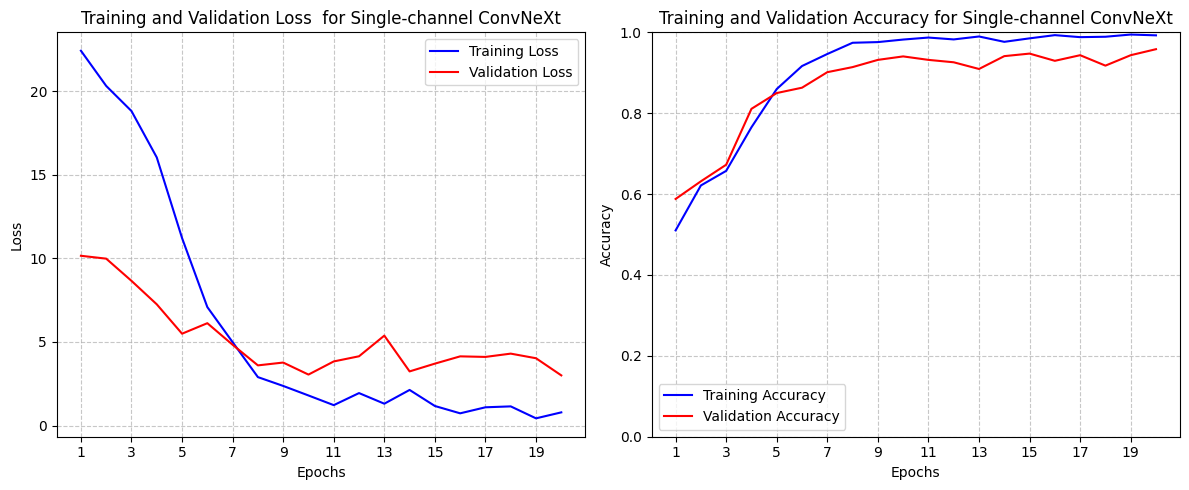

In [12]:
# transform images to greyscale and to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
single_channel_dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=transform)

# use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(single_channel_dataset))))
train_losses_per_fold, val_losses_per_fold, train_accs_per_fold, val_accs_per_fold, epochs_per_fold = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    sc_train_dataset = Subset(single_channel_dataset, train_idx)
    sc_test_dataset = Subset(single_channel_dataset, test_idx)


    sc_train_loader = DataLoader(
        sc_train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=4
    )

    sc_test_loader = DataLoader(
        sc_test_dataset, 
        batch_size=32, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    single_channel_model = MultiChannelConvNeXtSimple(num_channels=1, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
    single_channel_model.parameters(), 
    lr=5e-4,
    weight_decay=0.005,
    betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=20, 
    eta_min=1e-6
    )


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs, epoch_trained = train_model_with_visualization(
        single_channel_model, criterion, optimizer, sc_train_loader, sc_test_loader, train_loss_delta_threshold=0.1, test_loss_delta_threshold=0.1, moving_avg_window=3
    )

    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)
    train_accs_per_fold.append(train_accs)
    val_accs_per_fold.append(val_accs)
    epochs_per_fold.append(epoch_trained)

# average results across folds
zipped_val_losses = zip_longest(*val_losses_per_fold, fillvalue=None)
zipped_train_losses = zip_longest(*train_losses_per_fold, fillvalue=None)
zipped_train_accs = zip_longest(*train_accs_per_fold, fillvalue=None)
zipped_val_accs = zip_longest(*val_accs_per_fold, fillvalue=None)
avg_val_losses, avg_train_losses, avg_train_accs, avg_val_accs = [], [], [], []

for avg_list in [zipped_val_losses, zipped_train_losses, zipped_train_accs, zipped_val_accs]:
    average_values = []
    for values in avg_list:
        valid_values = [v for v in values if v is not None]
        average_values.append(np.mean(valid_values))
    if avg_list == zipped_val_losses:
        avg_val_losses = average_values
    elif avg_list == zipped_train_losses:
        avg_train_losses = average_values
    elif avg_list == zipped_train_accs:
        avg_train_accs = average_values
    elif avg_list == zipped_val_accs:
        avg_val_accs = average_values
plot_metrics(avg_train_losses, avg_val_losses, avg_train_accs, avg_val_accs, max(epochs_per_fold), 
title="Single-channel ConvNeXt", filename="single_channel_convnext_training_metrics.png")

In [43]:
# transform images to greyscale and to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Prepare the test dataset and loader
test_folder = '/home/mass_spec_img/mass_spec_img/data/einstein_patches_test/'
test_dataset_sc = SingleChannelDataset(folder_path=test_folder, transform=transform)
test_loader = DataLoader(test_dataset_sc, batch_size=32, shuffle=False, num_workers=4)

# use the last trained model for evaluation
single_channel_model.eval()
all_preds = []
channel_list = []
with torch.no_grad():
    for images, channels, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        channel_list.extend(list(channels))
        outputs = single_channel_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
# sort channel_list and reorder all_preds using the same order of indices
sorted_indices = sorted(range(len(channel_list)), key=lambda i: channel_list[i])
channel_list_sorted = [channel_list[i] for i in sorted_indices]
all_preds_sorted = [all_preds[i] for i in sorted_indices]

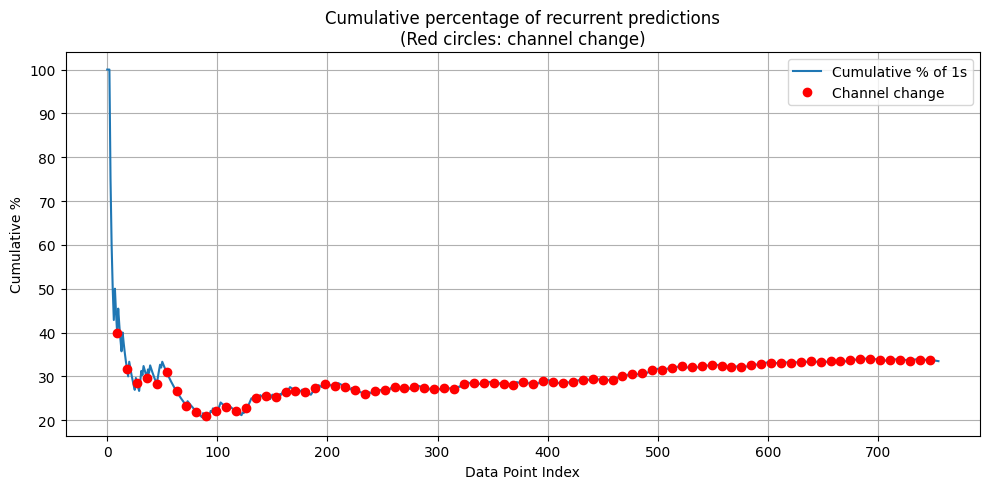

In [50]:
# calculate percentage of 1s up to each point in all_preds_sorted
all_preds_arr = np.array(all_preds_sorted)
percent_ones = np.cumsum(all_preds_arr == 1) / (np.arange(1, len(all_preds_arr) + 1)) * 100

# Identify indices where the channel changes
channel_arr = np.array(channel_list_sorted)
channel_change_indices = np.where(channel_arr[1:] != channel_arr[:-1])[0] + 1  # +1 to get the index of the new channel

plt.figure(figsize=(10, 5))
plt.plot(percent_ones, marker='', linestyle='-', label='Cumulative % of 1s')

# Highlight points where the channel changes
plt.plot(channel_change_indices, percent_ones[channel_change_indices], 'o', color='red', label='Channel change')

plt.xlabel('Data Point Index')
plt.ylabel('Cumulative %')
plt.title('Cumulative percentage of recurrent predictions\n(Red circles: channel change)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [49]:
# Prepare the test dataset and loader
test_folder = '/home/mass_spec_img/mass_spec_img/data/einstein_patches_test/'
test_dataset_mc = MultiChannelDataset(folder_path=test_folder, transform=None)
test_loader_mc = DataLoader(test_dataset_mc, batch_size=4, shuffle=False, num_workers=4)

# use the last trained model for evaluation
multi_channel_model.eval()
all_preds_mc = []
with torch.no_grad():
    for images, channels, labels in test_loader_mc:
        images = images.to(device)
        labels = labels.to(device)
        outputs = multi_channel_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds_mc.extend(preds.cpu().numpy())

print(all_preds_mc)

[1, 1, 1, 1, 1, 1, 1, 1, 1]


## Training Multi-channel Resnet Model

In [51]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2, dropout_p=0.5):
        """
        Modified ResNet model to handle multi-channel inputs beyond 3 channels, with added dropout for regularization.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
            dropout_p (float): Dropout probability (default: 0.5)
        """
        super(MultiChannelResnet, self).__init__()
        
        # load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # replace the layer
        self.model.conv1 = new_layer
        
        # Add dropout layer after the average pooling and before the final fully connected layer
        self.dropout = nn.Dropout(p=dropout_p)
        
        # modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network with dropout for regularization.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        # orward through all layers except the final FC
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # apply dropout before the final FC
        x = self.model.fc(x)
        return x


--- Fold 1 ---
epoch 1/20, Train loss: 1.4269, Train acc: 0.7500, Val loss: 1.0223, Val acc: 0.6667
epoch 2/20, Train loss: 0.1433, Train acc: 1.0000, Val loss: 1.6757, Val acc: 0.8333
epoch 3/20, Train loss: 0.1704, Train acc: 1.0000, Val loss: 0.2177, Val acc: 1.0000
epoch 4/20, Train loss: 0.2407, Train acc: 1.0000, Val loss: 5.9079, Val acc: 0.3333
epoch 5/20, Train loss: 0.0507, Train acc: 1.0000, Val loss: 4.8048, Val acc: 0.6667
epoch 6/20, Train loss: 2.1806, Train acc: 0.9167, Val loss: 0.0000, Val acc: 1.0000
epoch 7/20, Train loss: 0.0159, Train acc: 1.0000, Val loss: 0.0000, Val acc: 1.0000
epoch 8/20, Train loss: 0.0313, Train acc: 1.0000, Val loss: 0.0001, Val acc: 1.0000
Early stopping: moving average change in validation loss 0.000028 < threshold 0.05

--- Fold 2 ---
epoch 1/20, Train loss: 1.7096, Train acc: 0.5833, Val loss: 3.1140, Val acc: 0.1667
epoch 2/20, Train loss: 0.0988, Train acc: 1.0000, Val loss: 0.2247, Val acc: 0.8333
epoch 3/20, Train loss: 3.2303, Tra

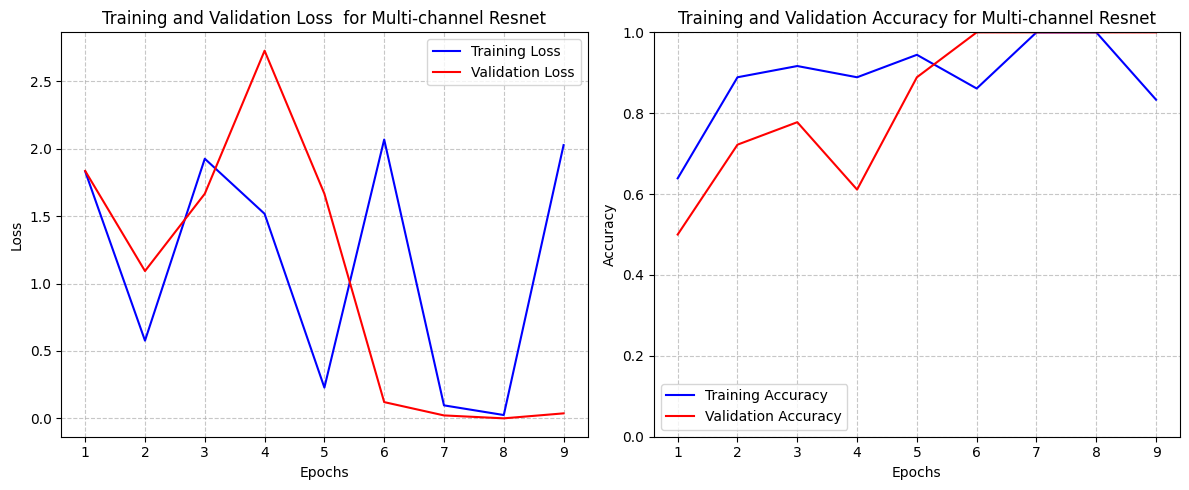

In [53]:
from itertools import product
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=None)

# use 3-fold cross-validation because there are 18 samples in the dataset
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(multi_channel_dataset))))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# rerun training with the best hyperparameters
fold_results = []
train_losses_per_fold, val_losses_per_fold, train_accs_per_fold, val_accs_per_fold, epochs_per_fold = [], [], [], [], []
for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    mc_train_dataset = Subset(multi_channel_dataset, train_idx)
    mc_test_dataset = Subset(multi_channel_dataset, test_idx)

    mc_train_loader = DataLoader(
        mc_train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=4
    )

    mc_test_loader = DataLoader(
        mc_test_dataset, 
        batch_size=4, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    multi_channel_model = MultiChannelResnet(num_channels=84, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(multi_channel_model.parameters(), lr=0.0005, weight_decay=1e-4)


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs, epoch_trained = train_model_with_visualization(
        multi_channel_model, criterion, optimizer, mc_train_loader, mc_test_loader
    )
    # Store results
    fold_results.append({
        'fold': fold+1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })
    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)
    train_accs_per_fold.append(train_accs)
    val_accs_per_fold.append(val_accs)
    epochs_per_fold.append(epoch_trained)

# average results across folds
zipped_val_losses = zip_longest(*val_losses_per_fold, fillvalue=None)
zipped_train_losses = zip_longest(*train_losses_per_fold, fillvalue=None)
zipped_train_accs = zip_longest(*train_accs_per_fold, fillvalue=None)
zipped_val_accs = zip_longest(*val_accs_per_fold, fillvalue=None)
avg_val_losses, avg_train_losses, avg_train_accs, avg_val_accs = [], [], [], []
for avg_list in [zipped_val_losses, zipped_train_losses, zipped_train_accs, zipped_val_accs]:
    average_values = []
    for values in avg_list:
        valid_values = [v for v in values if v is not None]
        average_values.append(np.mean(valid_values))
    if avg_list == zipped_val_losses:
        avg_val_losses = average_values
    elif avg_list == zipped_train_losses:
        avg_train_losses = average_values
    elif avg_list == zipped_train_accs:
        avg_train_accs = average_values
    elif avg_list == zipped_val_accs:
        avg_val_accs = average_values
plot_metrics(avg_train_losses, avg_val_losses, avg_train_accs, avg_val_accs, max(epochs_per_fold), title="Multi-channel Resnet", filename="multi_channel_resnet_training_metrics.png")





--- Fold 1 ---
epoch 1/20, Train loss: 17.0395, Train acc: 0.7907, Val loss: 37.2935, Val acc: 0.6746
epoch 2/20, Train loss: 6.4511, Train acc: 0.9137, Val loss: 2.7744, Val acc: 0.9306
epoch 3/20, Train loss: 2.6149, Train acc: 0.9752, Val loss: 2.0184, Val acc: 0.9484
epoch 4/20, Train loss: 2.4062, Train acc: 0.9772, Val loss: 9.4914, Val acc: 0.8671
epoch 5/20, Train loss: 1.1677, Train acc: 0.9861, Val loss: 2.7789, Val acc: 0.9306
epoch 6/20, Train loss: 0.9179, Train acc: 0.9891, Val loss: 4.6463, Val acc: 0.9226
epoch 7/20, Train loss: 1.7681, Train acc: 0.9802, Val loss: 2.2299, Val acc: 0.9504
epoch 8/20, Train loss: 1.2789, Train acc: 0.9851, Val loss: 1.9538, Val acc: 0.9563
epoch 9/20, Train loss: 0.6050, Train acc: 0.9931, Val loss: 2.8767, Val acc: 0.9345
epoch 10/20, Train loss: 0.5347, Train acc: 0.9931, Val loss: 3.4540, Val acc: 0.9405
epoch 11/20, Train loss: 0.2344, Train acc: 0.9980, Val loss: 1.3101, Val acc: 0.9702
Early stopping: moving average change in trai

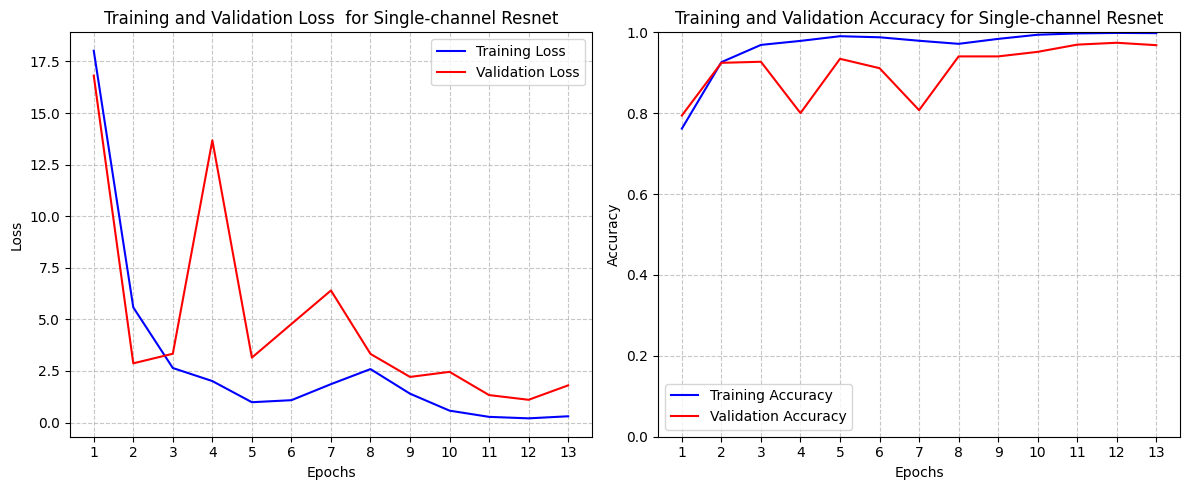

In [55]:
# transform images to greyscale and to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

single_channel_dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=transform)

# use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(single_channel_dataset))))
train_losses_per_fold, val_losses_per_fold, train_accs_per_fold, val_accs_per_fold, epochs_per_fold = [], [], [], [], []
# rerun training with the best hyperparameters
fold_results = []

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    sc_train_dataset = Subset(single_channel_dataset, train_idx)
    sc_test_dataset = Subset(single_channel_dataset, test_idx)


    sc_train_loader = DataLoader(
        sc_train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=4
    )

    sc_test_loader = DataLoader(
        sc_test_dataset, 
        batch_size=32, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    single_channel_model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(single_channel_model.parameters(), lr=0.001, weight_decay=1e-4)


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs, epoch_trained = train_model_with_visualization(
        single_channel_model, criterion, optimizer, sc_train_loader, sc_test_loader, train_loss_delta_threshold=0.2, test_loss_delta_threshold=0.2, moving_avg_window=3
    )

    # Store results
    fold_results.append({
        'fold': fold+1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })
    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)
    train_accs_per_fold.append(train_accs)
    val_accs_per_fold.append(val_accs)
    epochs_per_fold.append(epoch_trained)
# average results across folds
zipped_val_losses = zip_longest(*val_losses_per_fold, fillvalue=None)
zipped_train_losses = zip_longest(*train_losses_per_fold, fillvalue=None)
zipped_train_accs = zip_longest(*train_accs_per_fold, fillvalue=None)
zipped_val_accs = zip_longest(*val_accs_per_fold, fillvalue=None)
avg_val_losses, avg_train_losses, avg_train_accs, avg_val_accs = [], [], [], []
for avg_list in [zipped_val_losses, zipped_train_losses, zipped_train_accs, zipped_val_accs]:
    average_values = []
    for values in avg_list:
        valid_values = [v for v in values if v is not None]
        average_values.append(np.mean(valid_values))
    if avg_list == zipped_val_losses:
        avg_val_losses = average_values
    elif avg_list == zipped_train_losses:
        avg_train_losses = average_values
    elif avg_list == zipped_train_accs:
        avg_train_accs = average_values
    elif avg_list == zipped_val_accs:
        avg_val_accs = average_values
plot_metrics(avg_train_losses, avg_val_losses, avg_train_accs, avg_val_accs, max(epochs_per_fold), title="Single-channel Resnet", filename="single_channel_resnet_training_metrics.png")

In [ ]:
channel_dict = defaultdict(list)
for image, channel, label in single_channel_dataset:
    channel_dict[channel].append(image)

average_pred_acc_by_channel = {}
model.eval()  # use the trained model above
with torch.no_grad():
    for channel in channel_dict: 
        # get all (image, label) pairs for this channel
        test_data = [(img, chn, lbl) for img, chn, lbl in single_channel_dataset if chn == channel]
        if not test_data:
            average_pred_acc_by_channel[channel] = None
            continue
        test_images = torch.stack([img for img, chn, lbl in test_data]).to(device)
        test_labels = torch.tensor([lbl for img, chn, lbl in test_data]).to(device)
        outputs = model(test_images)
        _, preds = torch.max(outputs, 1)
        correct = (preds == test_labels).sum().item()
        acc = correct / len(test_labels)
        average_pred_acc_by_channel[channel] = acc
        print(f"Channel {channel} prediction accuracy: {acc:.4f}")

print("Average prediction accuracy by channel:")
print(average_pred_acc_by_channel)





Channel 444.885_1.1 prediction accuracy: 0.9444
Channel 784.520_1.4 prediction accuracy: 1.0000
Channel 948.468_1.5 prediction accuracy: 1.0000
Channel 786.516_1.4 prediction accuracy: 0.9444
Channel 790.491_1.4 prediction accuracy: 1.0000
Channel 850.564_1.5 prediction accuracy: 1.0000
Channel 835.610_1.5 prediction accuracy: 1.0000
Channel 744.503_1.4 prediction accuracy: 1.0000
Channel 782.521_1.4 prediction accuracy: 1.0000
Channel 785.443_1.4 prediction accuracy: 1.0000
Channel 739.453_1.4 prediction accuracy: 1.0000
Channel 948.534_1.5 prediction accuracy: 1.0000
Channel 949.526_1.5 prediction accuracy: 1.0000
Channel 833.585_1.5 prediction accuracy: 1.0000
Channel 844.463_1.5 prediction accuracy: 1.0000
Channel 828.538_1.5 prediction accuracy: 1.0000
Channel 711.440_1.3 prediction accuracy: 1.0000
Channel 834.574_1.5 prediction accuracy: 1.0000
Channel 834.518_1.4 prediction accuracy: 1.0000
Channel 851.587_1.5 prediction accuracy: 1.0000
Channel 824.542_1.4 prediction accuracy:

In [40]:
from sklearn.metrics import accuracy_score, f1_score


# transform images to greyscale and to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Prepare the test dataset and loader
test_folder = '/home/mass_spec_img/mass_spec_img/data/einstein_patches_test/'
test_dataset_sc = SingleChannelDataset(folder_path=test_folder, transform=transform)
test_loader_sc = DataLoader(test_dataset_sc, batch_size=32, shuffle=False, num_workers=4)


# Use the last trained model (from above) for evaluation
single_channel_model.eval()
all_preds = []

with torch.no_grad():
    for images, channels, labels in test_loader_sc:
        images = images.to(device)
        labels = labels.to(device)
        outputs = single_channel_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
print(all_preds.count(0)/ len(all_preds))


1.0


### Testing Model Performance with Eistein patches of size 64x64


--- Fold 1 ---
epoch 1/20, Train loss: 2.5420, Train acc: 0.4167, Val loss: 1.2313, Val acc: 0.8333
epoch 2/20, Train loss: 0.7026, Train acc: 0.8333, Val loss: 1.4011, Val acc: 0.8333
epoch 3/20, Train loss: 1.7443, Train acc: 0.6667, Val loss: 2.2055, Val acc: 0.8333
epoch 4/20, Train loss: 0.2668, Train acc: 0.9167, Val loss: 1.2686, Val acc: 0.8333
epoch 5/20, Train loss: 2.7445, Train acc: 0.7500, Val loss: 1.7775, Val acc: 0.5000
epoch 6/20, Train loss: 0.9721, Train acc: 0.9167, Val loss: 1.5012, Val acc: 0.5000
epoch 7/20, Train loss: 1.4097, Train acc: 0.8333, Val loss: 1.8084, Val acc: 0.6667
epoch 8/20, Train loss: 0.6998, Train acc: 0.8333, Val loss: 1.8690, Val acc: 0.8333
epoch 9/20, Train loss: 1.0464, Train acc: 0.8333, Val loss: 2.1772, Val acc: 0.8333
epoch 10/20, Train loss: 0.4429, Train acc: 0.9167, Val loss: 2.4215, Val acc: 0.5000
epoch 11/20, Train loss: 0.7146, Train acc: 0.8333, Val loss: 2.1732, Val acc: 0.3333
epoch 12/20, Train loss: 0.2662, Train acc: 1.0

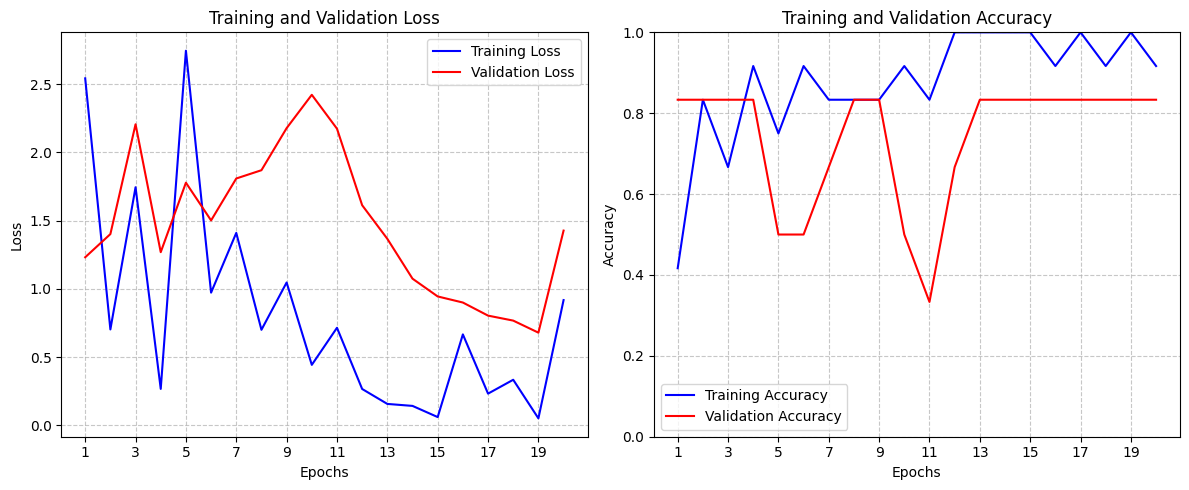


--- Fold 2 ---
epoch 1/20, Train loss: 3.0272, Train acc: 0.5000, Val loss: 1.7036, Val acc: 0.3333
epoch 2/20, Train loss: 0.6646, Train acc: 0.9167, Val loss: 3.0592, Val acc: 0.3333
epoch 3/20, Train loss: 1.2191, Train acc: 0.6667, Val loss: 1.7948, Val acc: 0.3333
epoch 4/20, Train loss: 0.5262, Train acc: 0.9167, Val loss: 1.8210, Val acc: 0.3333
epoch 5/20, Train loss: 2.9204, Train acc: 0.7500, Val loss: 8.6984, Val acc: 0.1667
epoch 6/20, Train loss: 0.1009, Train acc: 1.0000, Val loss: 11.1504, Val acc: 0.1667
epoch 7/20, Train loss: 2.6824, Train acc: 0.7500, Val loss: 7.0350, Val acc: 0.3333
epoch 8/20, Train loss: 0.1649, Train acc: 1.0000, Val loss: 4.0706, Val acc: 0.6667
epoch 9/20, Train loss: 0.1930, Train acc: 1.0000, Val loss: 2.8584, Val acc: 0.6667
epoch 10/20, Train loss: 0.1472, Train acc: 1.0000, Val loss: 2.3451, Val acc: 0.6667
epoch 11/20, Train loss: 0.3248, Train acc: 1.0000, Val loss: 2.5411, Val acc: 0.6667
epoch 12/20, Train loss: 0.0667, Train acc: 1.

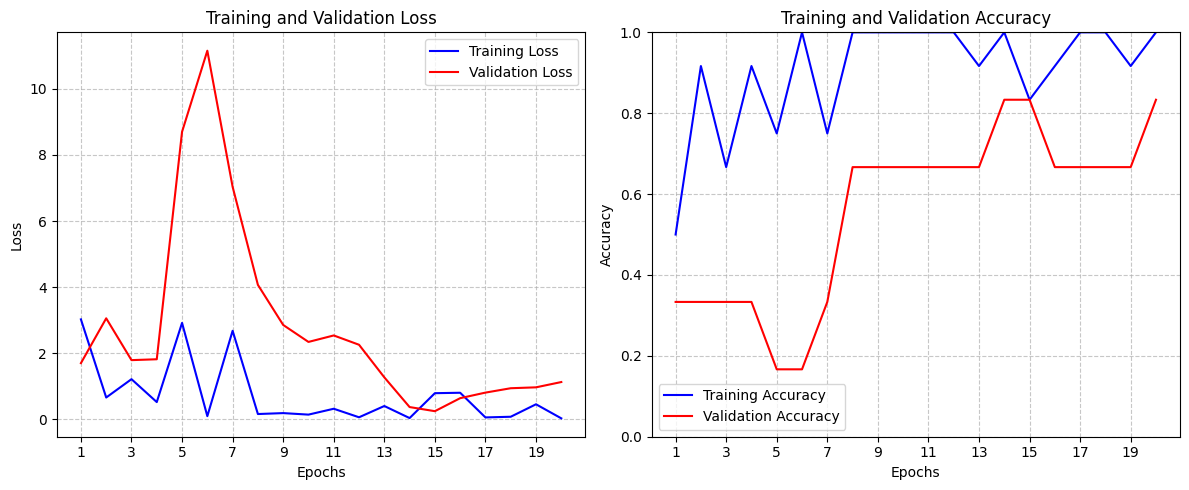


--- Fold 3 ---
epoch 1/20, Train loss: 1.8309, Train acc: 0.7500, Val loss: 4.1494, Val acc: 0.5000
epoch 2/20, Train loss: 2.8231, Train acc: 0.6667, Val loss: 13.2516, Val acc: 0.5000
epoch 3/20, Train loss: 0.4145, Train acc: 0.9167, Val loss: 15.3388, Val acc: 0.5000
epoch 4/20, Train loss: 0.9153, Train acc: 0.8333, Val loss: 1.1646, Val acc: 0.6667
epoch 5/20, Train loss: 0.3566, Train acc: 0.9167, Val loss: 1.5025, Val acc: 0.8333
epoch 6/20, Train loss: 0.2268, Train acc: 1.0000, Val loss: 1.1167, Val acc: 0.8333
epoch 7/20, Train loss: 1.3701, Train acc: 0.9167, Val loss: 1.0409, Val acc: 0.8333
epoch 8/20, Train loss: 0.8212, Train acc: 0.9167, Val loss: 3.2493, Val acc: 0.5000
epoch 9/20, Train loss: 0.1164, Train acc: 1.0000, Val loss: 3.9002, Val acc: 0.5000
epoch 10/20, Train loss: 2.6569, Train acc: 0.7500, Val loss: 3.7354, Val acc: 0.5000
epoch 11/20, Train loss: 0.0880, Train acc: 1.0000, Val loss: 3.2090, Val acc: 0.5000
epoch 12/20, Train loss: 3.1090, Train acc: 0

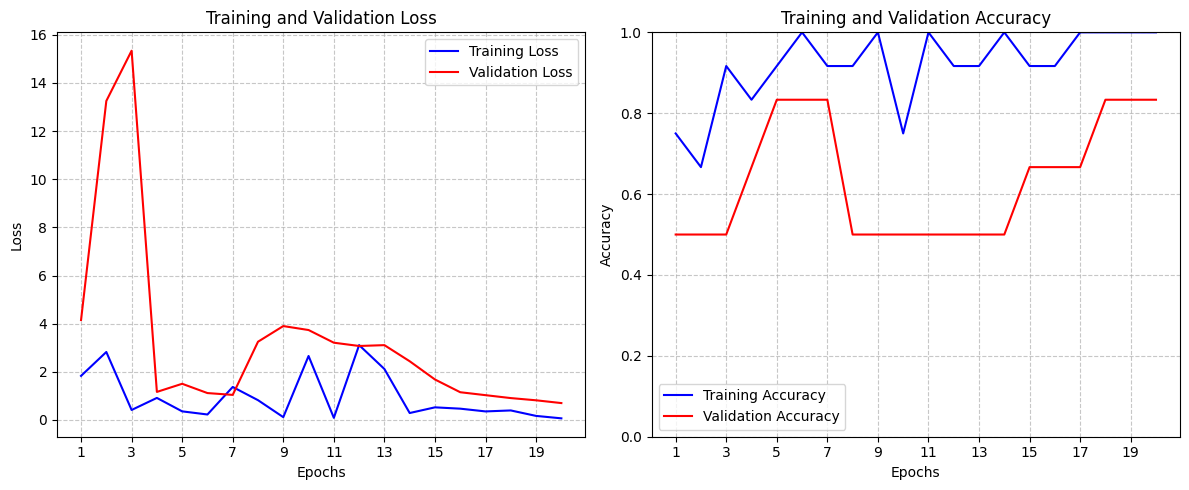


Average best validation accuracy across folds (rerun): 0.8333


In [ ]:
from itertools import product
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches_64/', transform=None)

# use 3-fold cross-validation because there are 18 samples in the dataset
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(multi_channel_dataset))))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# rerun training with the best hyperparameters
fold_results = []

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    mc_train_dataset = Subset(multi_channel_dataset, train_idx)
    mc_test_dataset = Subset(multi_channel_dataset, test_idx)

    mc_train_loader = DataLoader(
        mc_train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=4
    )

    mc_test_loader = DataLoader(
        mc_test_dataset, 
        batch_size=4, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    single_channel_model = MultiChannelResnet(num_channels=84, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(single_channel_model.parameters(), lr=0.0005, weight_decay=1e-4)


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs, epoch_trained = train_model_with_visualization(
        single_channel_model, criterion, optimizer, mc_train_loader, mc_test_loader
    )
    # Store results
    fold_results.append({
        'fold': fold+1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })

    # Plot metrics for this fold
    plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs=epoch_trained)

# Optionally, print summary statistics
avg_rerun_val_acc = sum([max(fr['val_accs']) for fr in fold_results]) / len(fold_results)
print(f"\nAverage best validation accuracy across folds (rerun): {avg_rerun_val_acc:.4f}")


### Single-Channel performance for einstein patches of size 64x64


--- Fold 1 ---
epoch 1/20, Train loss: 17.3767, Train acc: 0.7490, Val loss: 5.5342, Val acc: 0.8591
epoch 2/20, Train loss: 7.3575, Train acc: 0.9028, Val loss: 9.9763, Val acc: 0.7738
epoch 3/20, Train loss: 3.4334, Train acc: 0.9514, Val loss: 4.0995, Val acc: 0.8909
epoch 4/20, Train loss: 2.0119, Train acc: 0.9752, Val loss: 4.1166, Val acc: 0.9266
epoch 5/20, Train loss: 1.6935, Train acc: 0.9752, Val loss: 4.8777, Val acc: 0.9087
epoch 6/20, Train loss: 0.7578, Train acc: 0.9921, Val loss: 2.0646, Val acc: 0.9385
epoch 7/20, Train loss: 0.7180, Train acc: 0.9931, Val loss: 2.6579, Val acc: 0.9444
epoch 8/20, Train loss: 0.4030, Train acc: 0.9980, Val loss: 2.1913, Val acc: 0.9623
Early stopping: moving average change in training loss 0.177387 < threshold 0.2


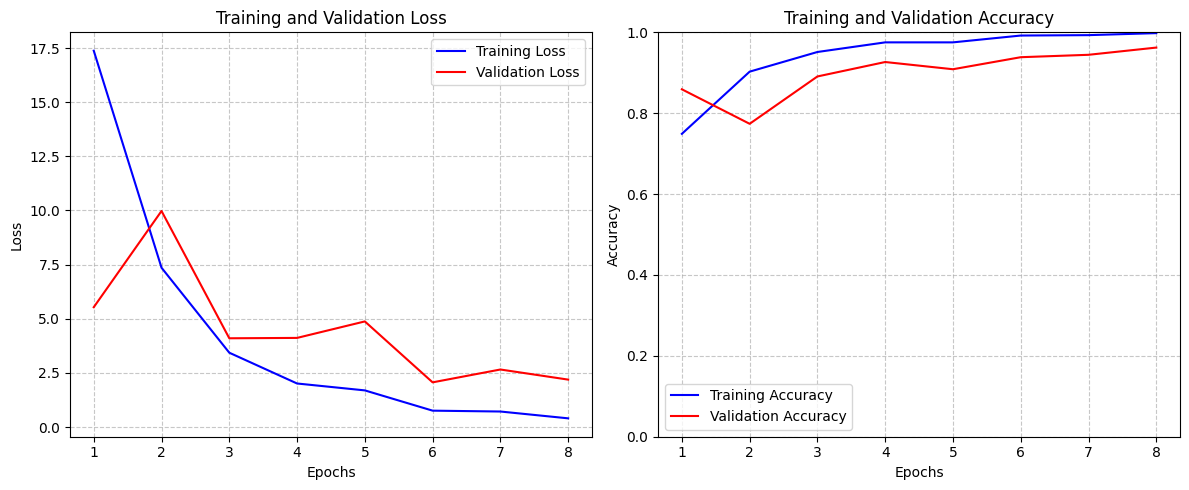


--- Fold 2 ---
epoch 1/20, Train loss: 19.0502, Train acc: 0.7282, Val loss: 36.3542, Val acc: 0.5992
epoch 2/20, Train loss: 6.7510, Train acc: 0.9087, Val loss: 5.4361, Val acc: 0.8790
epoch 3/20, Train loss: 4.2902, Train acc: 0.9375, Val loss: 2.2629, Val acc: 0.9405
epoch 4/20, Train loss: 1.7504, Train acc: 0.9792, Val loss: 3.3437, Val acc: 0.9226
epoch 5/20, Train loss: 1.2134, Train acc: 0.9881, Val loss: 4.6479, Val acc: 0.9028
epoch 6/20, Train loss: 0.9693, Train acc: 0.9921, Val loss: 3.9038, Val acc: 0.9246
epoch 7/20, Train loss: 0.7140, Train acc: 0.9921, Val loss: 3.8937, Val acc: 0.9147
epoch 8/20, Train loss: 0.6811, Train acc: 0.9950, Val loss: 4.0754, Val acc: 0.9286
Early stopping: moving average change in training loss 0.144060 < threshold 0.2
Early stopping: moving average change in validation loss 0.095809 < threshold 0.2


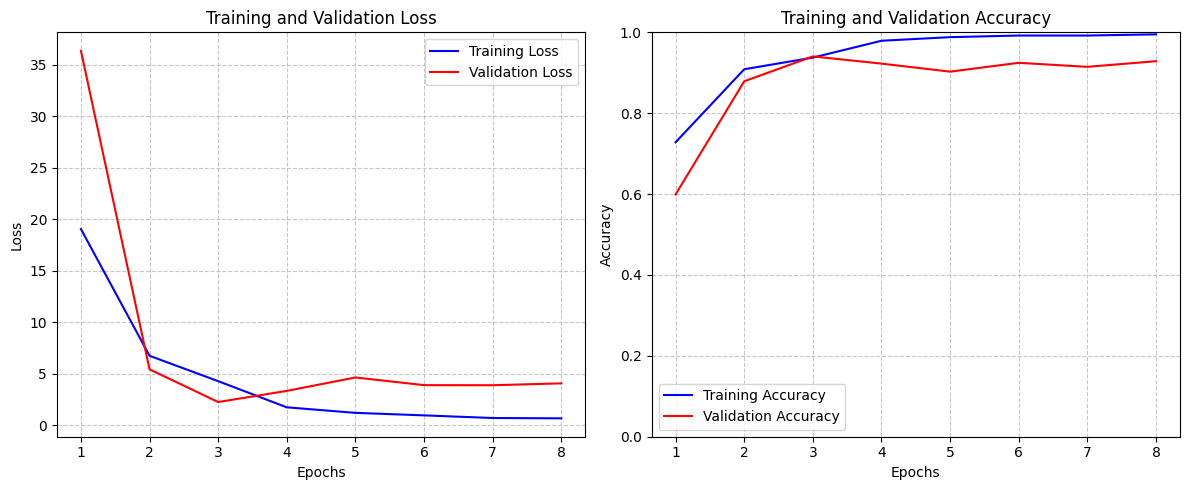


--- Fold 3 ---
epoch 1/20, Train loss: 17.3853, Train acc: 0.7401, Val loss: 7.0992, Val acc: 0.8056
epoch 2/20, Train loss: 7.5083, Train acc: 0.9117, Val loss: 10.7647, Val acc: 0.7917
epoch 3/20, Train loss: 5.6970, Train acc: 0.9167, Val loss: 4.5723, Val acc: 0.8869
epoch 4/20, Train loss: 2.2284, Train acc: 0.9752, Val loss: 2.6870, Val acc: 0.9385
epoch 5/20, Train loss: 2.2552, Train acc: 0.9772, Val loss: 3.1674, Val acc: 0.9286
epoch 6/20, Train loss: 1.2621, Train acc: 0.9871, Val loss: 2.8225, Val acc: 0.9246
epoch 7/20, Train loss: 0.8439, Train acc: 0.9960, Val loss: 2.3167, Val acc: 0.9504
epoch 8/20, Train loss: 1.8586, Train acc: 0.9802, Val loss: 9.1467, Val acc: 0.8393
epoch 9/20, Train loss: 1.2543, Train acc: 0.9851, Val loss: 4.0147, Val acc: 0.9325
epoch 10/20, Train loss: 1.1396, Train acc: 0.9891, Val loss: 2.6881, Val acc: 0.9425
epoch 11/20, Train loss: 2.3364, Train acc: 0.9772, Val loss: 5.6719, Val acc: 0.8948
epoch 12/20, Train loss: 0.8243, Train acc: 0

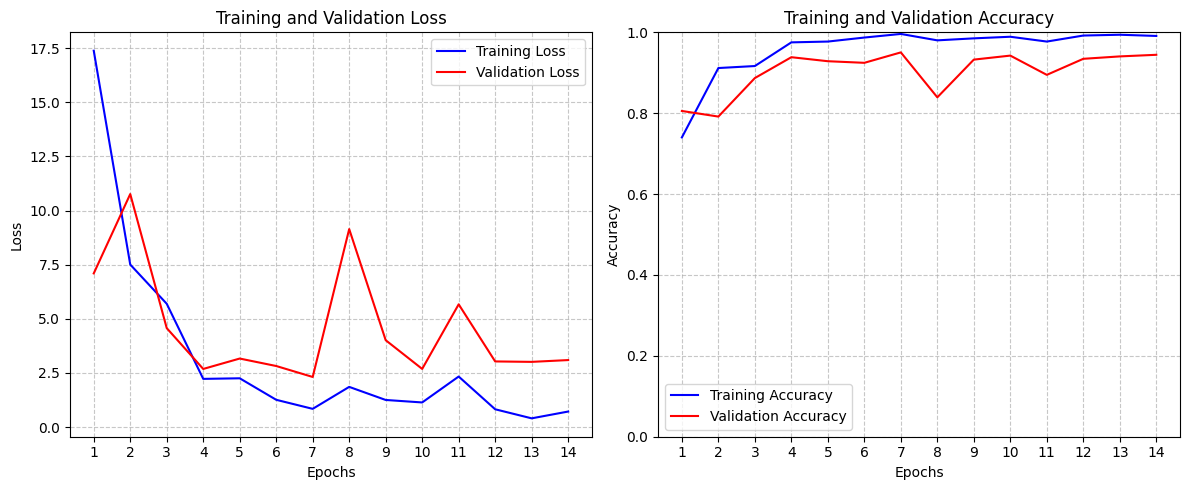


Average best validation accuracy across folds (rerun): 0.9511


In [ ]:
# transform images to greyscale and to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

single_channel_dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches_64/', transform=transform)
# use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_indices = list(kf.split(range(len(single_channel_dataset))))
# rerun training with the best hyperparameters
fold_results = []

for fold, (train_idx, test_idx) in enumerate(fold_indices):
    print(f"\n--- Fold {fold+1} ---")
    sc_train_dataset = Subset(single_channel_dataset, train_idx)
    sc_test_dataset = Subset(single_channel_dataset, test_idx)


    sc_train_loader = DataLoader(
        sc_train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=4
    )

    sc_test_loader = DataLoader(
        sc_test_dataset, 
        batch_size=32, 
        shuffle=False,
        num_workers=4
    )

    # Initialize model, criterion, optimizer
    single_channel_model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(single_channel_model.parameters(), lr=0.0005, weight_decay=1e-4)


    # Train and get metrics
    train_losses, val_losses, train_accs, val_accs, epoch_trained = train_model_with_visualization(
        single_channel_model, criterion, optimizer, sc_train_loader, sc_test_loader, train_loss_delta_threshold=0.2, test_loss_delta_threshold=0.2, moving_avg_window=3
    )

    # Store results
    fold_results.append({
        'fold': fold+1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })

    # Plot metrics for this fold
    plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs=epoch_trained)
# Optionally, print summary statistics
avg_rerun_val_acc = sum([max(fr['val_accs']) for fr in fold_results]) / len(fold_results)
print(f"\nAverage best validation accuracy across folds (rerun): {avg_rerun_val_acc:.4f}")